In [1]:
library(igraph, warn.conflicts = F, verbose = F)
library(foreach, warn.conflicts = F, verbose = F)
library(doParallel, warn.conflicts = F, verbose = F)
library(ggplot2)

Loading required package: iterators

Loading required package: parallel



In [2]:
totalCores = detectCores()

In [3]:
cluster <- makeCluster(totalCores[1]-1) 
registerDoParallel(cluster)

In [4]:
alpha<-0.01
n<-5000
p<-5/n

In [5]:
metric<-function(g){
    betweenness(g)
}

In [6]:
alphas<-seq(from=0.01, to=0.9, by=0.02)

In [7]:
results <- foreach(index_alpha = 1:length(alphas), .combine = cbind) %dopar% {
    library(igraph, warn.conflicts = F, verbose = F)
    
    percent<-vector()
    counts<-vector()
    for (i in 1:10) {

        g <- sample_gnp(n, p)
        V(g)$cst_ids <- c(1:n)
        V(g)$load <- metric(g)
        V(g)$capacity <- (1 + alphas[index_alpha]) * V(g)$load

        nodes_to_fail <- order(V(g)$load, decreasing = T)[1]
        cst_ids_failed <- V(g)$cst_ids[nodes_to_fail]

        g_failed <- g

        counter <- 0

        while (length(nodes_to_fail > 0)) {
            g_failed <- delete_vertices(g_failed, nodes_to_fail)

            V(g_failed)$new_load <- metric(g_failed)

            failing_nodes <- V(g_failed)$new_load > V(g_failed)$capacity

            nodes_to_fail <- V(g_failed)[failing_nodes]

            cst_ids_failed <- c(cst_ids_failed, V(g_failed)$cst_ids[nodes_to_fail])

            counter <- counter + 1
        }

        percent[i] <- length(g_failed)/length(g)
        counts[i]<- counter
    }
    
    return(c(mean(percent), sqrt(var(percent)), mean(counts)))
}

In [8]:
rownames(results)<- c('mean', 'std', 'counts')
results<-t(results)
res<-cbind(results, alphas)

colnames(res)<- c('mean', 'std', 'counts', 'alphas')

rownames(res)<-NULL

res<-as.data.frame(res)

In [59]:
write.csv(res, 'er_p5_n_10attempts.csv')

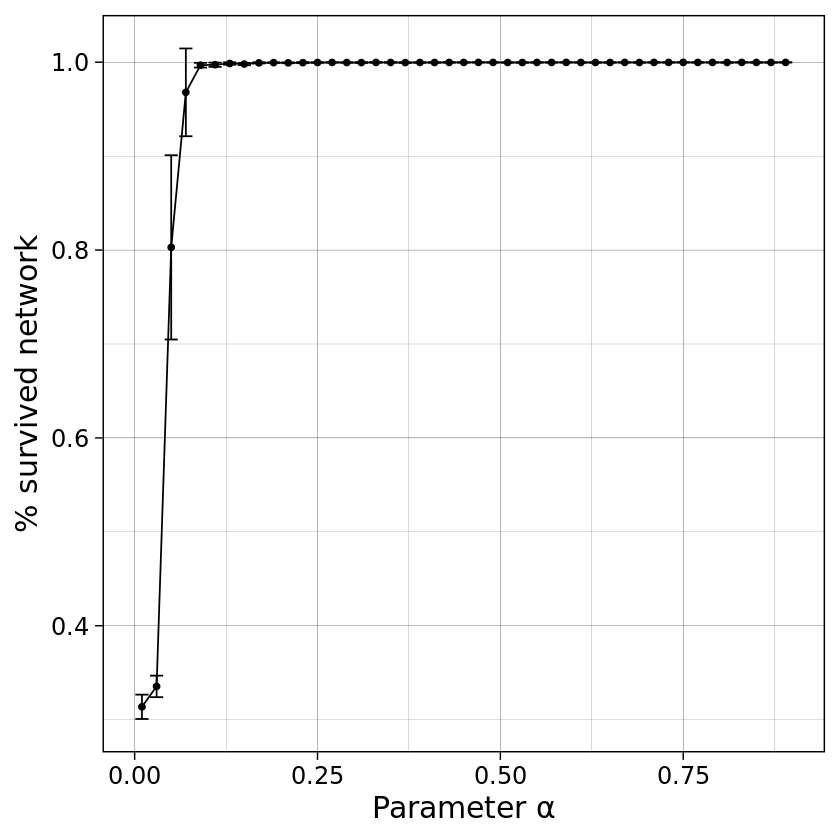

In [56]:
ggplot(res, aes(x = alphas, y = mean)) + geom_line() + geom_point() + geom_errorbar(aes(ymin = mean -
    std, ymax = mean + std)) + labs(x = expression(paste("Parameter ", alpha)), y = "% survived network") +
    theme_linedraw(  base_size = 18,) + scale_color_manual(values = c("#999999",
    "#E69F00"), )

In [13]:
#Stop cluster
stopCluster(cluster)